# Finding a 2D SSM from sloshing data
This is an example of how a slow 2D SSM can be fitted to experiment data to predict the system's forced response. This example uses measurements of the center of mass displacement of the liquid in a horizontally excited sloshing tank [1].

[1] B. Bäuerlein and K. Avila, Phase-lag predicts nonlinear response maxima in liquid-sloshing experiments, Journal of Fluid Mechanics 925 (2021) A22. https://doi.org/10.1017/jfm.2021.576


For more info on the anaylsis, see the original implementation at https://github.com/mattiacenedese/SSMLearn/tree/main/examples/sloshing

and the paper

[2] M. Cenedese, J. Axås, B. Bäuerlein, K. Avila and G. Haller. Data-driven modeling and prediction of non-linearizable dynamics via spectral submanifolds. Nature Communications, 13 (2022) 872.

# Example setup
The data consists of three decaying center of mass signals, along with data points of the forced response at three forcing amplitudes. SSMLearn is trained only on the decaying data and predicts a forced response that agrees well with the data points from the forced system. 

The training trajectories were measured by exciting the tank and then detaching the motor, at three different frequencies, allowing free resonance decay. The data is assumed to lie close to the slowest 2D SSM.

In [1]:
import numpy as np
from scipy.io import loadmat

In [2]:
from ssmlearnpy import SSMLearn
import matplotlib.pyplot as plt

In [3]:
from ssmlearnpy.geometry.coordinates_embedding import coordinates_embedding

In [4]:
datadir = 'data/'
frcExp = [np.loadtxt(datadir + 'Measurements_A=0.09%.txt', skiprows=1),
          np.loadtxt(datadir + 'Measurements_A=0.17%.txt', skiprows=1),
          np.loadtxt(datadir + 'Measurements_A=0.32%.txt', skiprows=1)]

In [5]:


amplitudes = [0.09, 0.17, 0.32]

xData = loadmat(datadir + 'xData')['xData']
decayFrequencies = [0.953, 0.960, 0.967]
titles = []
for iFreq in range(len(decayFrequencies)):
    titles.append('$\Omega = ' + str(decayFrequencies[iFreq]) + '$')
indTrain = [0, 2]
indTest = [1]

In [6]:
t_test = [np.squeeze(xData[indTest, 0][0])]
x_test = [xData[indTest, 1][0]]

# Delay embedding

Now we arrange the scalar measurements in an observable space of dimension at least $2m+1$, with $m$ the dimension of the manifold. This guarantees that the manifold from the full state space can be embedded in the observable space.
We form a multi-dimensional observable by stacking $d$ subsequent scalar measurements $x$ in a vector $y$, and we will later use the trajectories in this augmented space for the manifold fitting.

$$
\left[\begin{array}{c}y_{1} \\ \vdots \\ y_{i+1} \\ \vdots \\ y_{d+1}\end{array} 
\right] = \left[\begin{array}{c}x(t^k) \\ \vdots \\ x(t^k+i\Delta t) \\ \vdots 
\\ x(t^k+d\Delta t)\end{array} \right]
$$

In [56]:
ssm = SSMLearn(
    t = [np.squeeze(xData[indTrain, 0][0]), np.squeeze(xData[indTrain, 0][1])],
    x = [xData[indTrain, 1][0], xData[indTrain, 1][1]], 
    ssm_dim=2, 
    dynamics_type = 'flow',
    dynamics_structure = 'normalform'
)

INFO   2023-07-26 01:20:01 main Getting coordinates embeddings
INFO   2023-07-26 01:20:01 coordinates_embedding The 5 embedding coordinates consist of the measured state and its 4 time-delayed measurements.


In [57]:
from ssmlearnpy.utils.plots import Plot

plotter = Plot(
    label_observables = 'q',
    label_reduced_coordinates = 'eta'
)

In [58]:
## to force the plots to render
# might need to uncomment jupyterlab
import plotly.io as pio
#pio.renderers.default='notebook'
pio.renderers.default='jupyterlab'


We may show the trajectories embedded in the observable space.

In [59]:
fig = plotter.make_plot(ssm, data_name = 'observables', idx_trajectories=[0, 1], idx_coordinates=[0, 1, 2],
                        with_predictions = False)


In [60]:
fig.show()

# Manifold fitting

The measured trajectories are assumed to lie close to a two-dimensional manifold that is tangent at the origin to the eigenspace corresponding to the slowest pair of eigenvalues. We now want to fit a polynomial of order  to the data points to approximate the manifold. Here we use a graph style parametrization, meaning that the manifold is parametrized using coordinates in the computed eigenspace $V_e$. This excludes the possibility of folds on the manifold (however, if necessary we may circumvent this problem by increasing the dimensionality of the observed space). 

In [61]:
ssm.get_parametrization(poly_degree = 2)
#ssm.get_reduced_coordinates(method = 'linearchart')

INFO   2023-07-26 01:20:03 ridge Transforming data
INFO   2023-07-26 01:20:03 ridge Skipping CV on ridge regression
INFO   2023-07-26 01:20:03 ridge Fitting regression model


Now both ```ssm.decoder``` and ```ssm.encoder``` are fitted.

## we plot the manifold in the observable space and the reduced corrdinates. 

In [62]:
fig = plotter.make_plot(ssm, data_name = 'observables', idx_trajectories=[0, 1], idx_coordinates=[0, 1, 2],
                        with_predictions = False, add_surface = True)
fig.show()

In [63]:
fig = plotter.make_plot(ssm, data_name = 'reduced_coordinates', 
                        idx_trajectories=[0, 1], idx_coordinates=[1,2],
                        with_predictions = False)
fig.show()

# Reduced order model

We compute a model for the reduced dynamics with the truncated training data projected onto the manifold. The function ```ssm.get_reduced_dynamics()``` fits a polynomial map
$$
\dot{\eta} = W_r \phi(\eta)
$$

where $\phi(\eta)$ computes a vector of all monomials of $\eta$, and $W_r$ is a matrix of polynomial coefficients. 
We are also specifying that we want the reduced dynamics on a normal form, and seek the Taylor expansion of a map  fulfilling

$$
\dot{z} = N(z) =Dz + W_n\phi(z)
$$

with $D$ a diagonal matrix and $W_n$ containing coefficients for the near-resonant nonlinear terms, after a near-identity change of coordinates

$$
z = T^{-1}(\eta) = \eta + W_t \phi(\eta)
$$

with $W_t$ containing the coefficients for the nonlinear terms of the coordinate change.

In [75]:
ssm.get_reduced_dynamics(poly_degree = 3, normalform_args = {'degree': 3, 
                                                             'do_scaling': False,
                                                             'tolerance': None, 'ic_style': 'random', 'method': 'lm', 'jac': '2-point', 'max_iter': 1000})

INFO   2023-07-26 01:21:41 ridge Transforming data
INFO   2023-07-26 01:21:41 ridge Skipping CV on ridge regression
INFO   2023-07-26 01:21:41 ridge Fitting regression model


We also delay embed the test data: 

In [76]:
t_test, x_test, _ = coordinates_embedding(t_test, x_test,
                                               imdim = ssm.ssm_dim)

In [77]:
x_reduced_test = ssm.encode(x_test)

# The normal form-style reduced dynamics can be used separately to predict trajectories


It uses the linear part of the previously identified reduced dynamics, which is stored in 
```ssm.reduced_dynamics.map_info['coefficients']```

We can then display the identified reduced dynamics in complex variables as 

In [78]:
import ssmlearnpy.utils.postprocessing as postprocessing

In [79]:
var, varbar, eqs = postprocessing.display_equation(ssm.reduced_dynamics.map_info['coefficients'], ssm.reduced_dynamics.map_info['exponents'], base_symbol='z', complex=True)



In [80]:
postprocessing.disp('\\dot{z}_0=', eqs[0])
postprocessing.disp('\\dot{\\bar{z}}_0=', eqs[1])

or in polar coordinates as 


In [81]:
variables = [var[0], varbar[0]]
r, phi, req, phieq = postprocessing.convert_to_polar(variables, eqs)

In [82]:
postprocessing.disp('\\dot{r}_0=', req[0])
postprocessing.disp('\\dot{\\varphi}_0=', phieq[0])


In [83]:
import matplotlib.pyplot as plt

In [84]:
from scipy.integrate import solve_ivp

### Predict 

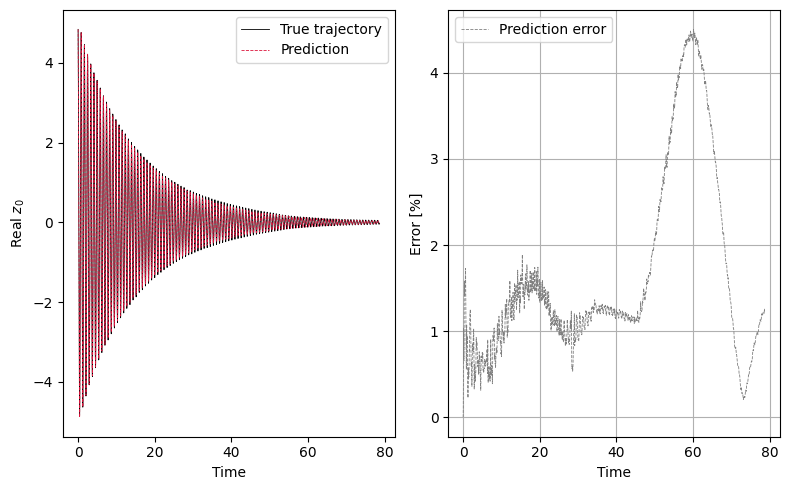

In [86]:
f = plt.figure(figsize = (8,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
flag_label = True
for i, t in enumerate(x_reduced_test):
    normal_form_true = ssm.normalform_transformation.inverse_transform(t)
    ic = normal_form_true[:,0]
    time_pred = t_test[i]
    pred = solve_ivp(ssm.reduced_dynamics.map_info['vectorfield'], [time_pred[0], time_pred[-1]], ic, t_eval=time_pred, method = 'DOP853')
    tonorm = np.max(np.abs(normal_form_true[0,:]))
    error = np.abs(pred.y[0,:] - normal_form_true[0,:])/tonorm
    if flag_label:
        ax.plot(t_test[i], np.real(normal_form_true[0,:]), '-', c='black',  linewidth = 0.6,label = 'True trajectory')
        ax.plot(t_test[i], np.real(pred.y[0,:]), '--',  linewidth = 0.6,c='Crimson', label = 'Prediction')
        ax2.plot(t_test[i], error*100, '--',linewidth =0.6, c='grey', label = 'Prediction error')
        
    else:
        ax.plot(t_test[i], np.real(normal_form_true[0,:]), '-', c='black',  linewidth = 0.6)
        ax.plot(t_test[i], np.real(pred.y[0,:]), '--',  linewidth = 0.6,c='Crimson')
        ax2.plot(t_test[i], error*100, '--',linewidth =0.6, c='grey')
    flag_label = False
        
#ax.set_xlim(0, 1000)
ax.legend()
ax2.legend()
ax.set_xlabel('Time')

ax2.set_xlabel('Time')
ax.set_ylabel('Real $z_0$')
ax2.set_ylabel('Error [%]')
ax2.grid()
f.tight_layout()

/Users/balintkaszas/opt/anaconda3/envs/ssmlearn/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning:

Casting complex values to real discards the imaginary part



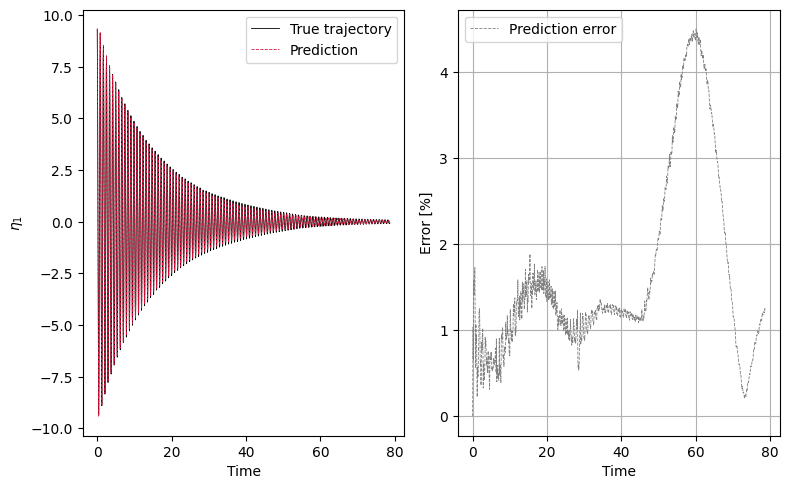

In [87]:
f = plt.figure(figsize = (8,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
flag_label = True
for i, t in enumerate(x_reduced_test):
    normal_form_true = ssm.normalform_transformation.inverse_transform(t)
    ic = normal_form_true[:,0]
    time_pred = t_test[i]
    pred = solve_ivp(ssm.reduced_dynamics.map_info['vectorfield'], [time_pred[0], time_pred[-1]], ic, t_eval=time_pred, method = 'DOP853')
    prediction_in_redcoord = ssm.normalform_transformation.transform(pred.y)
    if flag_label:
        ax.plot(t_test[i], t[0,:], '-', c='black',  linewidth = 0.6,label = 'True trajectory')
        ax.plot(t_test[i], prediction_in_redcoord[0,:], '--',  linewidth = 0.6,c='Crimson', label = 'Prediction')
        ax2.plot(t_test[i], error*100, '--',linewidth =0.6, c='grey', label = 'Prediction error')
        
#ax.set_xlim(0, 1000)
ax.legend()
ax2.legend()
ax.set_xlabel('Time')

ax2.set_xlabel('Time')
ax.set_ylabel('$\\eta_1$')
ax2.set_ylabel('Error [%]')
ax2.grid()
f.tight_layout()

# Backbone curves

With the knowledge of the coefficients of the normal form, we extract backbone curves for the instantaneous damping and frequency.

In [88]:
import sympy as sy

In [89]:
(toplot_backbone_curve, backbone_symbolic), (toplot_damping_curve, damping_symbolic) = postprocessing.backbone_curve_and_damping_curve(r, phieq, req)







In [90]:
rtoplot = np.linspace(0, 1, 100)

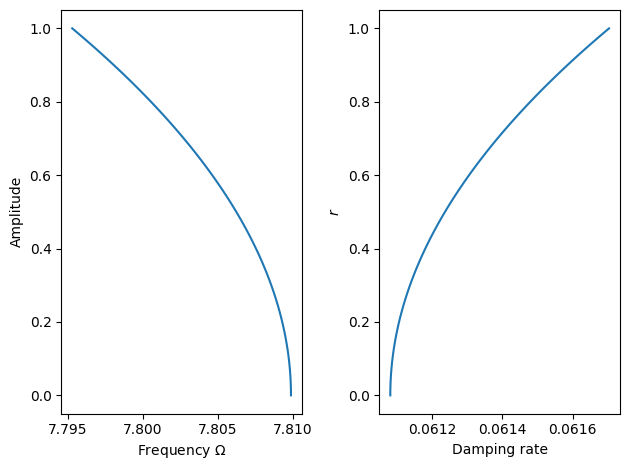

In [91]:
f = plt.figure()
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.plot(toplot_backbone_curve(rtoplot), rtoplot,'-')
ax2.plot(toplot_damping_curve(rtoplot), rtoplot,'-')

ax.set_xlabel('Frequency $\\Omega$')
ax.set_ylabel('Amplitude')
ax2.set_xlabel('Damping rate')
ax2.set_ylabel('$r$')

plt.tight_layout()

# Compute forced response curves
The data-driven model trained on autonomous data can now be used for forced response predictions. With the addition of forcing, the normal form dynamics becomes 

$\dot{z} =N(z) + f_{red} e^{i\Omega t}$

where $\Omega$ is the forcing frequency and $f_{red}$  is the forcing amplitude. For FRC extraction, we analytically compute fixed points of the polar normal form via a closed form solution.

We need to define the forcing amplitude in the normal form.

In [92]:
w_span = np.array([0.87, 1.06])*7.8


V = ssm.encoder.matrix_representation


In [93]:
embedDim = 5

In [94]:
outdof = int(np.floor(embedDim/2)+1) - 1

In [95]:
maxmode = np.argmax(np.abs(V[outdof,:]))

In [96]:
Omega = []

In [97]:
yCal = []

In [98]:

for iAmp in range(len(amplitudes)):
    uCal = np.max(frcExp[iAmp][:,1])
    pos = np.argmax(frcExp[iAmp][:,1])
    
    Omega.append(frcExp[iAmp][pos,0]*7.8)
    yCal.append(uCal*V[:,maxmode]/V[outdof,maxmode])



In [99]:
yCal = np.array(yCal).T

In [102]:
zCal = ssm.normalform_transformation.inverse_transform(ssm.encode(yCal[:,iAmp].reshape(-1,1)))


In [103]:
ndof = 1
nAmp = yCal.shape[1]
fRed = np.zeros((nAmp,ndof))
for iAmp in range(len(amplitudes)):
    
    
    zCal = ssm.normalform_transformation.inverse_transform(ssm.encode(yCal[:,iAmp].reshape(-1,1)))
    rhoCal = np.abs(zCal[:ndof,:])
    fRed[iAmp,:] = np.sqrt(rhoCal**2.*(toplot_backbone_curve(rhoCal)-Omega[iAmp])**2 
                           + rhoCal**2.*(toplot_damping_curve(rhoCal))**2)


In [104]:
fRed

array([[0.12835239],
       [0.24744371],
       [0.47335671]])

The forced response curves are given by the solutions $\rho_0$ of the equation

$$
\Omega = \omega(\rho_0) + \sqrt{\frac{f^2}{\rho_0^2}-\alpha^2(\rho_0)}
$$

The corresponding phase of the response is 

$$
\Psi_0 = \arctan \left ( \frac{\alpha(\rho_0)}{\omega(\rho_0) - \Omega}\right )
$$

In [105]:
calibration_amplitude = fRed[2]

In [106]:
rhs_to_eval = lambda r : calibration_amplitude **2 / r**2 - toplot_damping_curve(r)**2


In [107]:
rhoo = np.linspace(0.001, 0.19, 100)
omega1  = toplot_backbone_curve(rhoo) - np.sqrt(rhs_to_eval(rhoo))
omega2  = toplot_backbone_curve(rhoo) + np.sqrt(rhs_to_eval(rhoo))

## Comparing the FRC predictions to experiments

We iterate over the experimental data and compute the predictions with the three values of the calibration amplitude.

In [113]:
frequencies = []
amplitudes = []
phases = []

In [115]:
for calib_amp in fRed:
    
    _, omega, _, _, u, uph = postprocessing.extract_FRC((toplot_backbone_curve, backbone_symbolic),
                                                        (toplot_damping_curve, damping_symbolic),
                                                        calib_amp,
                                                        ssm.normalform_transformation,
                                                       ssm.decoder.predict,
                                                        3
                                                       )
    frequencies.append(omega)
    amplitudes.append(u)
    phases.append(uph)





/Users/balintkaszas/SSMLearnPy/ssmlearnpy/utils/postprocessing.py:158: RuntimeWarning:

invalid value encountered in sqrt



Text(0, 0.5, 'Amplitude')

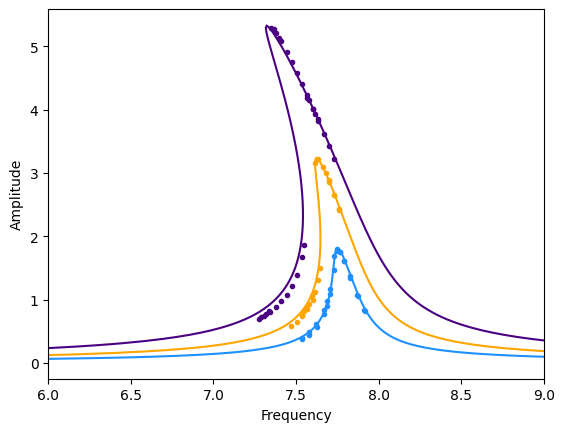

In [116]:
colors = ['Dodgerblue', 'orange', 'indigo']
for i in range(len(frcExp)):
    plt.plot(frequencies[i][0,:],amplitudes[i][0].T, '-', c= colors[i])
    plt.plot(frequencies[i][1,:],amplitudes[i][1].T, '-', c= colors[i])
    plt.plot(frcExp[i][:,0]*7.8, frcExp[i][:,1], '.',  c= colors[i])
    
plt.xlim(6,9)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')